<a href="https://colab.research.google.com/github/saicharan-r/Erav1/blob/main/S8/S8-layer_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from tqdm import tqdm

from Model import Model
from Model import NormalizationMethod

In [62]:
is_cuda_available = torch.cuda.is_available()
device=torch.device("cuda" if is_cuda_available else "cpu")
print("the model uses the device = ",device)

the model uses the device =  cuda


In [63]:
train_transforms=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
        transforms.Resize((32,32)),
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
        transforms.Resize((32, 32), antialias=False),  # type: ignore
    ]
)

In [64]:
cifar10_train=CIFAR10('./data',train=True,transform=train_transforms,download=True)
cifar10_test=CIFAR10('./data',train=True, transform=test_transforms, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True)
    if cuda
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(cifar10_train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(cifar10_test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


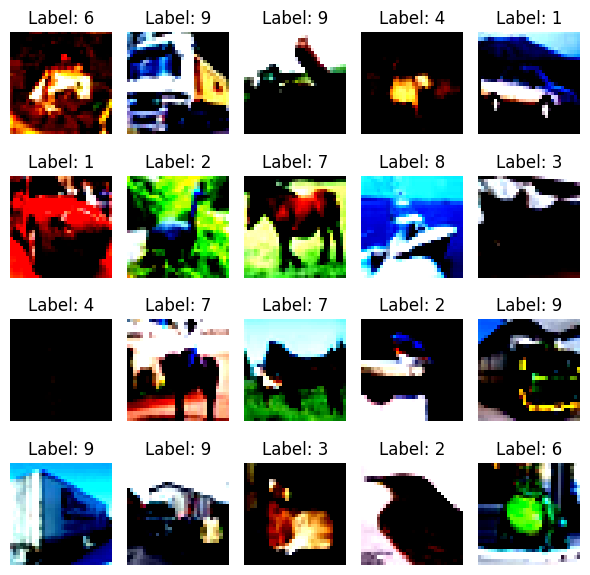

In [66]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    image, label = cifar10_train[i]
    image = image.permute(1, 2, 0)  # Reshape tensor to (32, 32, 3) for visualization
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Label: {label}')
plt.tight_layout()
plt.show()

MODEL

In [67]:

model = Model(NormalizationMethod.LAYER).to(device)
summary(
    model,
    input_size=(3, 32, 32)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
         GroupNorm-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,152
        GroupNorm-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14           [-1, 16,

In [68]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
        )
        train_acc.append(100 * correct / processed)

    # epoch accuracy = accuracy for the whole batch
    epoch_train_acc.append(100 * correct / processed)
    return 100 * correct / processed


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    test_acc.append(100.0 * correct / len(test_loader.dataset))

In [69]:


model = Model(NormalizationMethod.LAYER).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=0)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    accuracy = train(model, device, train_loader, optimizer, epoch)
    scheduler.step(accuracy)
    test(model, device, test_loader)

EPOCH: 0


LR=0.3 Loss=1.9347505569458008 Batch_id=390 Accuracy=21.28: 100%|██████████| 391/391 [00:23<00:00, 16.59it/s]


Test set: Average loss: 1.9184, Accuracy: 14084/50000 (28.17%)

EPOCH: 1


LR=0.3 Loss=1.889330506324768 Batch_id=390 Accuracy=33.68: 100%|██████████| 391/391 [00:23<00:00, 16.59it/s]


Test set: Average loss: 1.7130, Accuracy: 17855/50000 (35.71%)

EPOCH: 2


LR=0.3 Loss=1.4928290843963623 Batch_id=390 Accuracy=39.32: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]


Test set: Average loss: 1.5353, Accuracy: 21487/50000 (42.97%)

EPOCH: 3


LR=0.3 Loss=1.4228825569152832 Batch_id=390 Accuracy=44.31: 100%|██████████| 391/391 [00:23<00:00, 16.52it/s]


Test set: Average loss: 1.3961, Accuracy: 24396/50000 (48.79%)

EPOCH: 4


LR=0.3 Loss=1.3064892292022705 Batch_id=390 Accuracy=47.58: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]


Test set: Average loss: 1.3588, Accuracy: 24932/50000 (49.86%)

EPOCH: 5


LR=0.3 Loss=1.3909311294555664 Batch_id=390 Accuracy=50.35: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]


Test set: Average loss: 1.2896, Accuracy: 26336/50000 (52.67%)

EPOCH: 6


LR=0.3 Loss=1.3822574615478516 Batch_id=390 Accuracy=52.96: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s]


Test set: Average loss: 1.2962, Accuracy: 26205/50000 (52.41%)

EPOCH: 7


LR=0.3 Loss=1.137666940689087 Batch_id=390 Accuracy=55.61: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


Test set: Average loss: 1.2571, Accuracy: 27238/50000 (54.48%)

EPOCH: 8


LR=0.3 Loss=1.0041342973709106 Batch_id=390 Accuracy=57.67: 100%|██████████| 391/391 [00:23<00:00, 16.29it/s]


Test set: Average loss: 1.1144, Accuracy: 29858/50000 (59.72%)

EPOCH: 9


LR=0.3 Loss=1.2782679796218872 Batch_id=390 Accuracy=59.30: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s]


Test set: Average loss: 1.0717, Accuracy: 30914/50000 (61.83%)

EPOCH: 10


LR=0.3 Loss=1.0473237037658691 Batch_id=390 Accuracy=60.82: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]


Test set: Average loss: 1.0338, Accuracy: 31556/50000 (63.11%)

EPOCH: 11


LR=0.3 Loss=1.0606684684753418 Batch_id=390 Accuracy=62.20: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]


Test set: Average loss: 0.9628, Accuracy: 32877/50000 (65.75%)

EPOCH: 12


LR=0.3 Loss=1.1380271911621094 Batch_id=390 Accuracy=63.59: 100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


Test set: Average loss: 0.9830, Accuracy: 32239/50000 (64.48%)

EPOCH: 13


LR=0.3 Loss=0.8895871043205261 Batch_id=390 Accuracy=64.48: 100%|██████████| 391/391 [00:24<00:00, 15.88it/s]


Test set: Average loss: 0.9930, Accuracy: 32359/50000 (64.72%)

EPOCH: 14


LR=0.3 Loss=1.0148813724517822 Batch_id=390 Accuracy=65.16: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s]


Test set: Average loss: 0.9198, Accuracy: 33706/50000 (67.41%)

EPOCH: 15


LR=0.3 Loss=0.8838791847229004 Batch_id=390 Accuracy=65.80: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]


Test set: Average loss: 0.9766, Accuracy: 32240/50000 (64.48%)

EPOCH: 16


LR=0.3 Loss=0.8791788816452026 Batch_id=390 Accuracy=66.65: 100%|██████████| 391/391 [00:23<00:00, 16.58it/s]


Test set: Average loss: 0.8569, Accuracy: 34634/50000 (69.27%)

EPOCH: 17


LR=0.3 Loss=0.8573773503303528 Batch_id=390 Accuracy=67.03: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]


Test set: Average loss: 0.8336, Accuracy: 35082/50000 (70.16%)

EPOCH: 18


LR=0.3 Loss=1.0487552881240845 Batch_id=390 Accuracy=68.04: 100%|██████████| 391/391 [00:23<00:00, 16.77it/s]


Test set: Average loss: 0.8306, Accuracy: 35134/50000 (70.27%)

EPOCH: 19


LR=0.3 Loss=0.9200462102890015 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]


Test set: Average loss: 0.8603, Accuracy: 34730/50000 (69.46%)

